In [1]:
# Regression Models
%matplotlib inline
#%matplotlib widget
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from collections import Counter
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor,
RandomForestRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor)

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report, f1_score)

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [2]:
df = pd.read_csv('FMCG_2022_2024.csv', engine='pyarrow')
df.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


In [3]:
# Data Integrity Check
print("Big Query Statistics:")
print('-' * 127)
print(f"🚣‍♀️ DataFrame Shape: {df.shape}")
print('-' * 127)
print(f"Columns to list:\n{df.columns.tolist()}")
print('-' * 127)
print(f"📊 DataFrame Info: {df.info(memory_usage='deep')}")
print('-' * 127)
print(f"📈 DataFrame Distribution:\n {df.describe()}")
print('-' * 127)

missing_values = df.isna().sum()
#today_date = datetime.date.today() #+ datetime.timedelta(days=2) # test function works
#date_count = pd.DataFrame(jobs_all.date_time.dt.date.value_counts())
#missing_dates = list(pd.date_range(start=first_date, end=today_date).difference(date_count.index))
if len(missing_values) < 0:
    print("❌ Missing data for following columns:")
else:
    print(f"✅ No missing values for df:\n{missing_values}")

Big Query Statistics:
-------------------------------------------------------------------------------------------------------------------------------
🚣‍♀️ DataFrame Shape: (190757, 14)
-------------------------------------------------------------------------------------------------------------------------------
Columns to list:
['date', 'sku', 'brand', 'segment', 'category', 'channel', 'region', 'pack_type', 'price_unit', 'promotion_flag', 'delivery_days', 'stock_available', 'delivered_qty', 'units_sold']
-------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190757 entries, 0 to 190756
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             190757 non-null  object 
 1   sku              190757 non-null  object 
 2   brand            190757 non-null  object 
 3   segment   

In [4]:
# Value_counts - Unique
objects = df.select_dtypes(include=['object','category'])
for col in objects.columns:
    #print(f"\n{col}:")
    print(f"{'='*127}")
    print(df[col].value_counts())

date
2024-07-30    248
2024-06-16    247
2023-08-02    247
2023-08-31    246
2023-11-20    244
             ... 
2022-02-24     13
2022-01-24     13
2022-02-27     13
2022-01-22     12
2022-01-21      8
Name: count, Length: 1076, dtype: int64
sku
MI-006    8221
MI-026    8216
YO-029    7909
YO-005    7893
YO-012    7719
RE-004    7643
YO-014    7630
YO-001    7574
RE-007    7489
RE-015    7366
MI-023    7202
JU-021    6943
YO-009    6778
SN-027    6435
YO-003    6341
MI-022    6249
YO-016    5991
RE-025    5990
SN-010    5870
RE-017    5748
SN-013    5501
YO-020    5416
SN-019    5229
MI-002    5067
MI-011    4863
YO-024    4850
MI-008    4777
SN-028    4749
YO-018    4606
SN-030    4492
Name: count, dtype: int64
brand
SnBrand2    26775
YoBrand4    22317
YoBrand3    18981
MiBrand3    18228
YoBrand2    17349
ReBrand4    14855
YoBrand1    14060
MiBrand1    13084
ReBrand2    11738
MiBrand4     8216
ReBrand1     7643
JuBrand3     6943
SnBrand3     5501
MiBrand2     5067
Name: count, dtype:

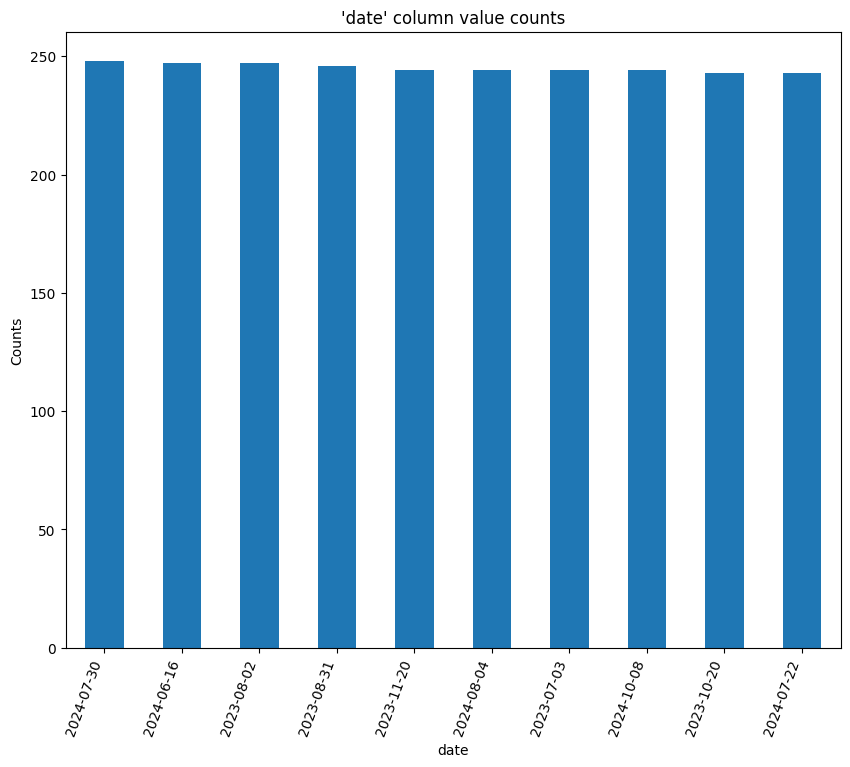

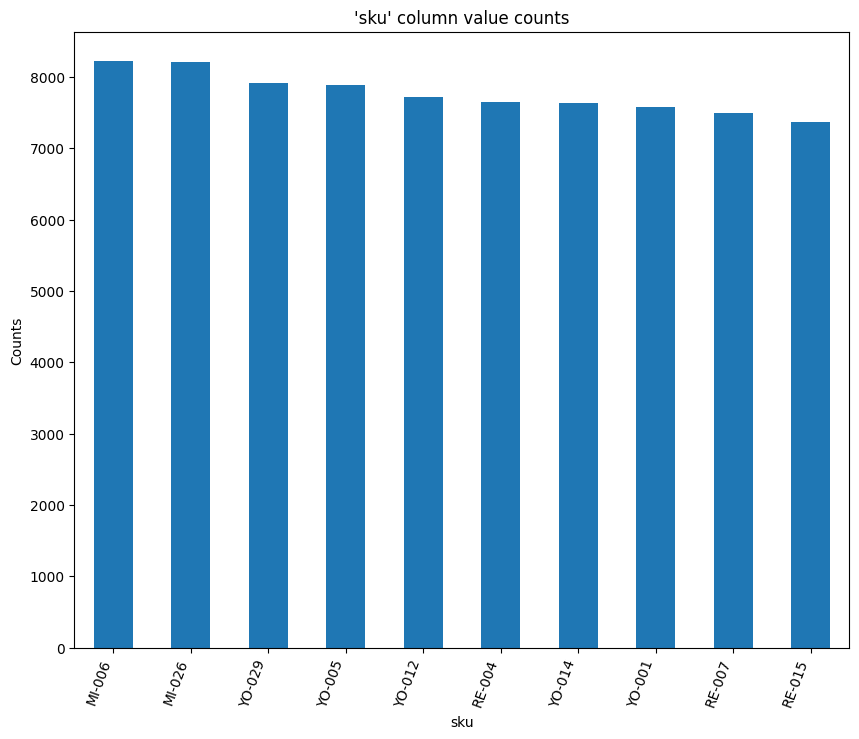

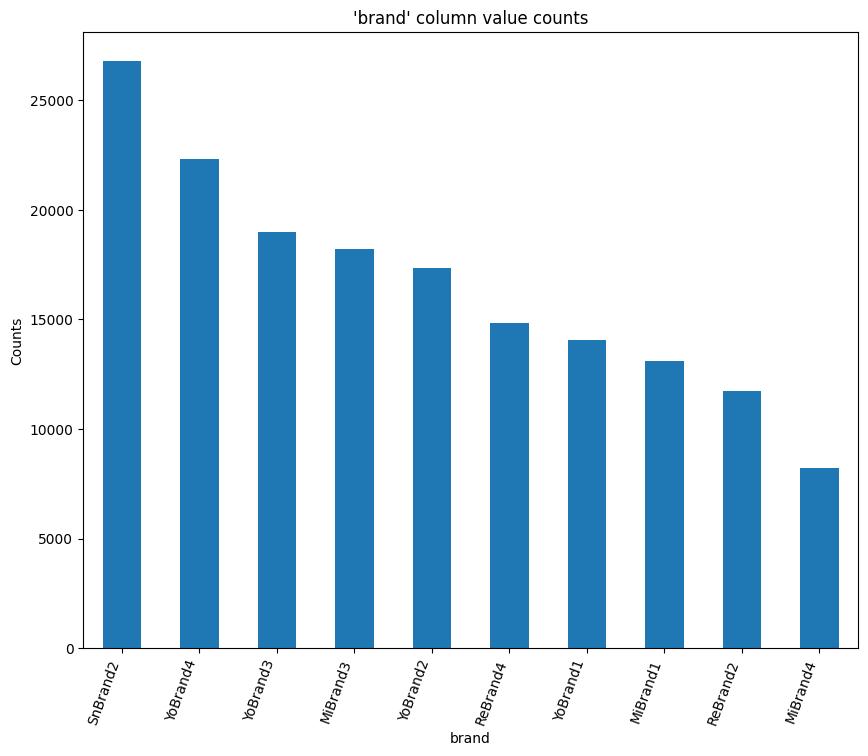

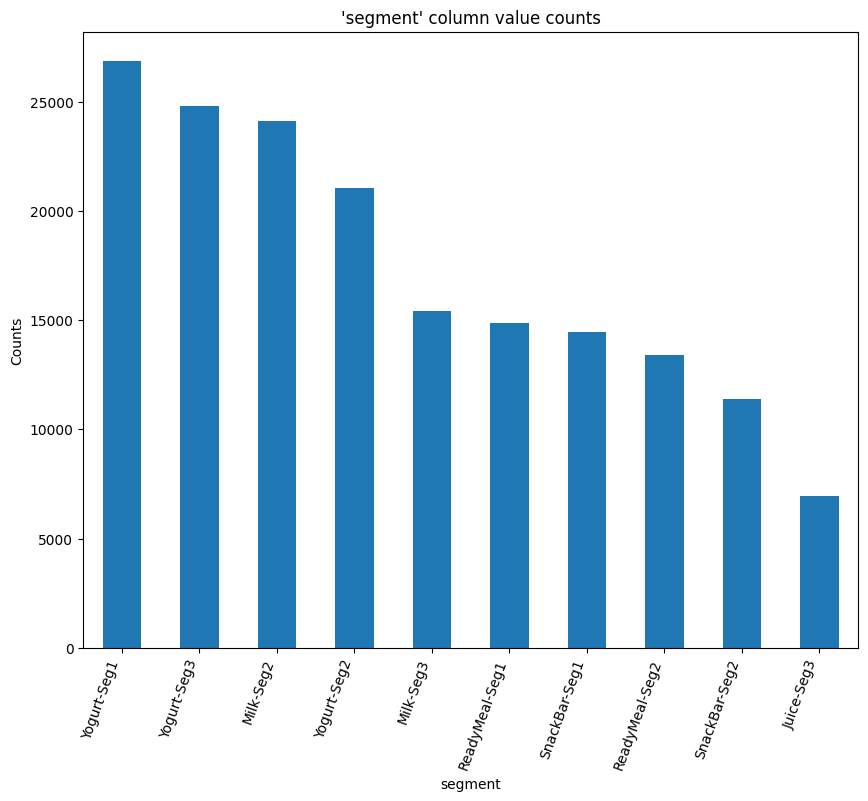

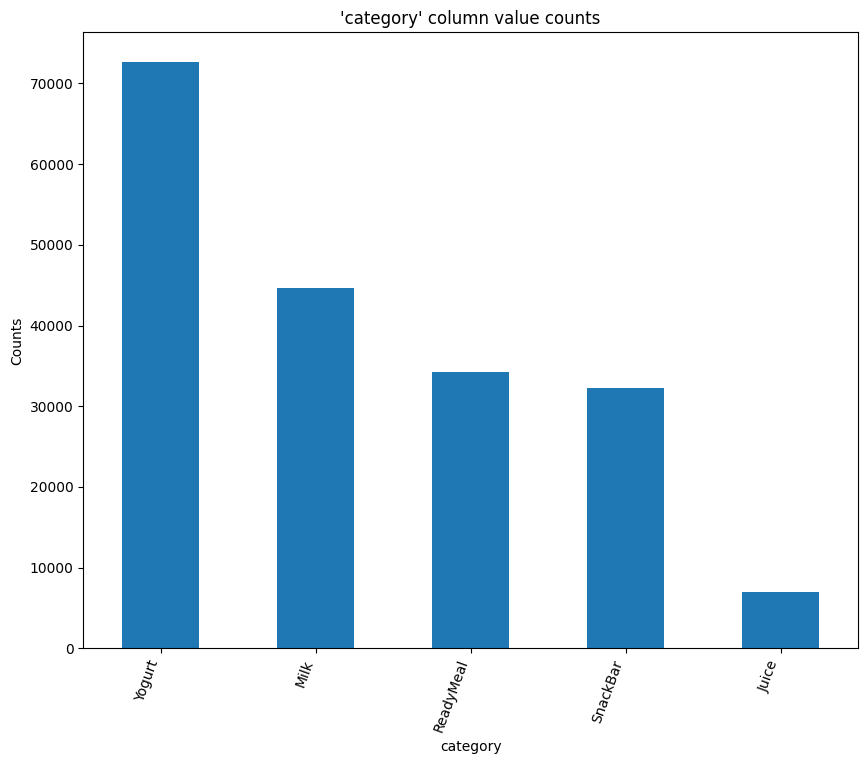

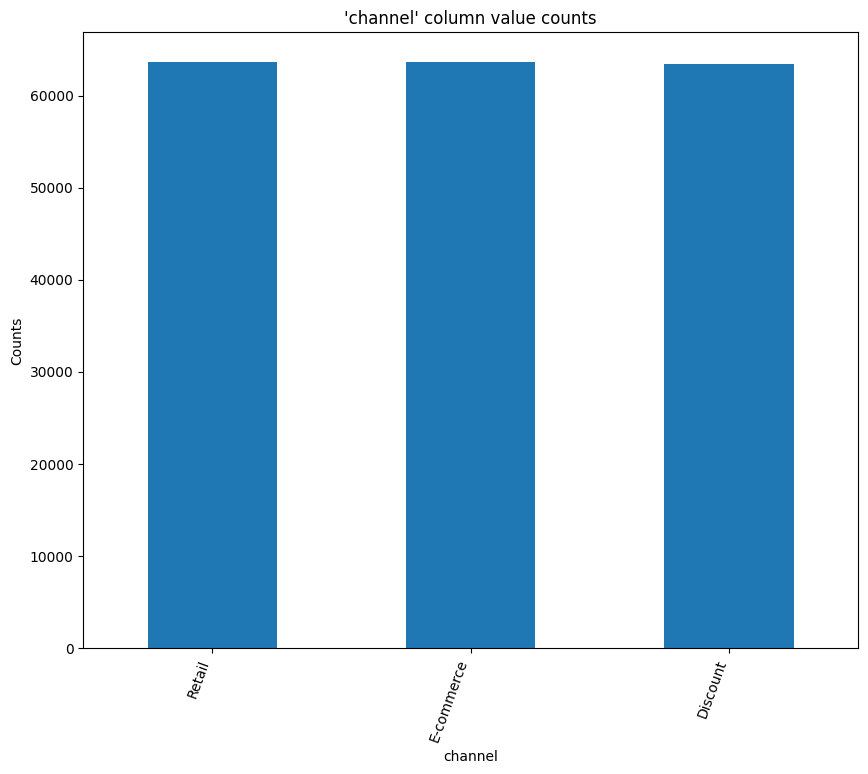

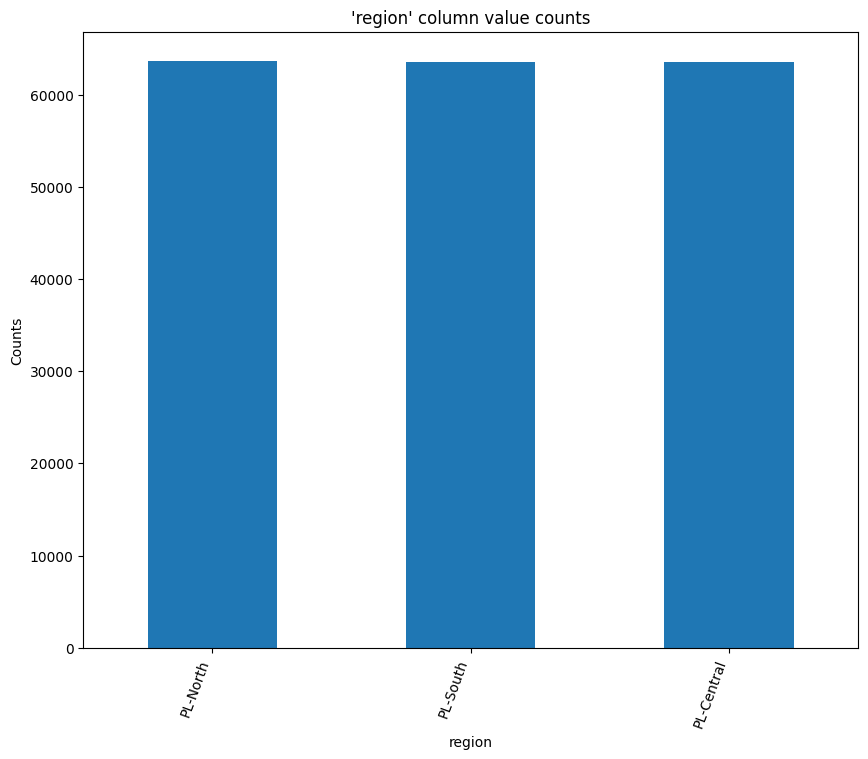

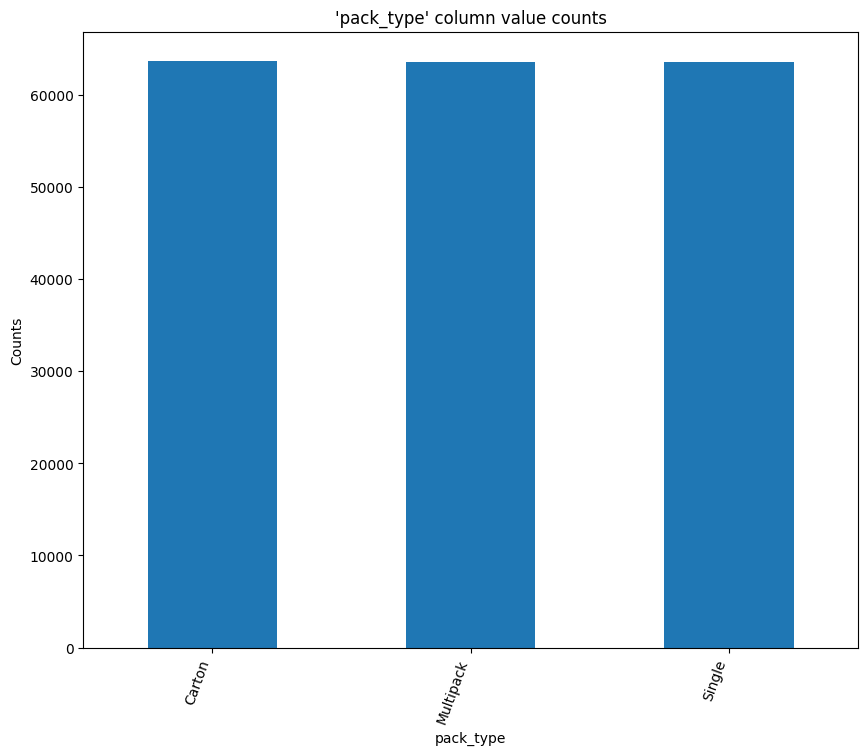

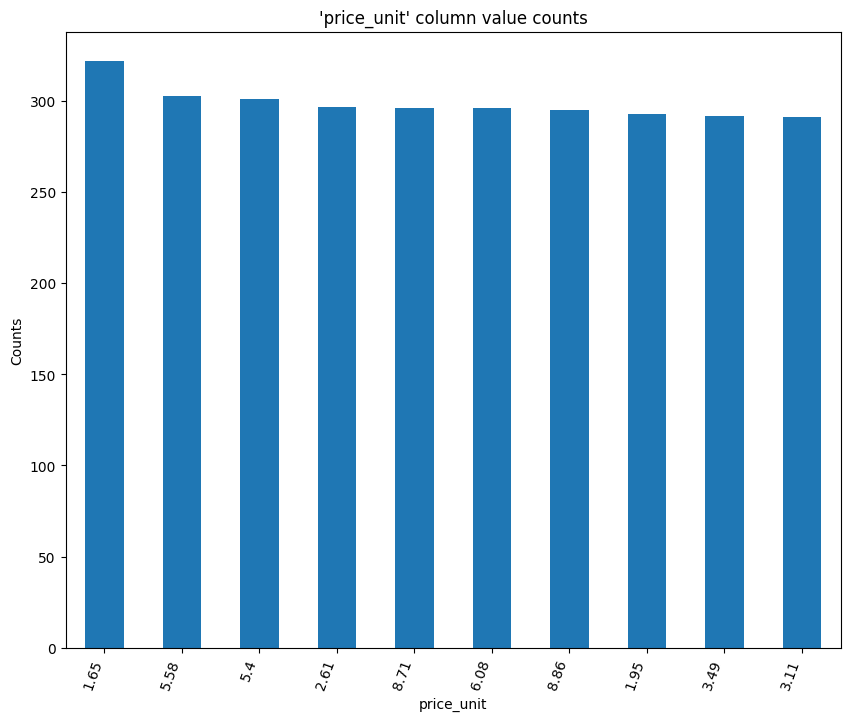

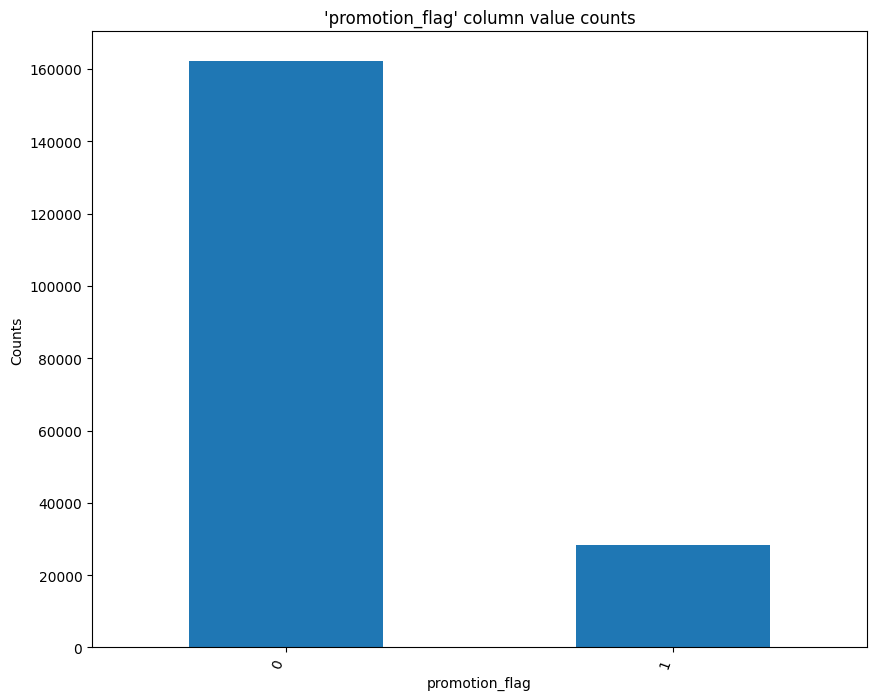

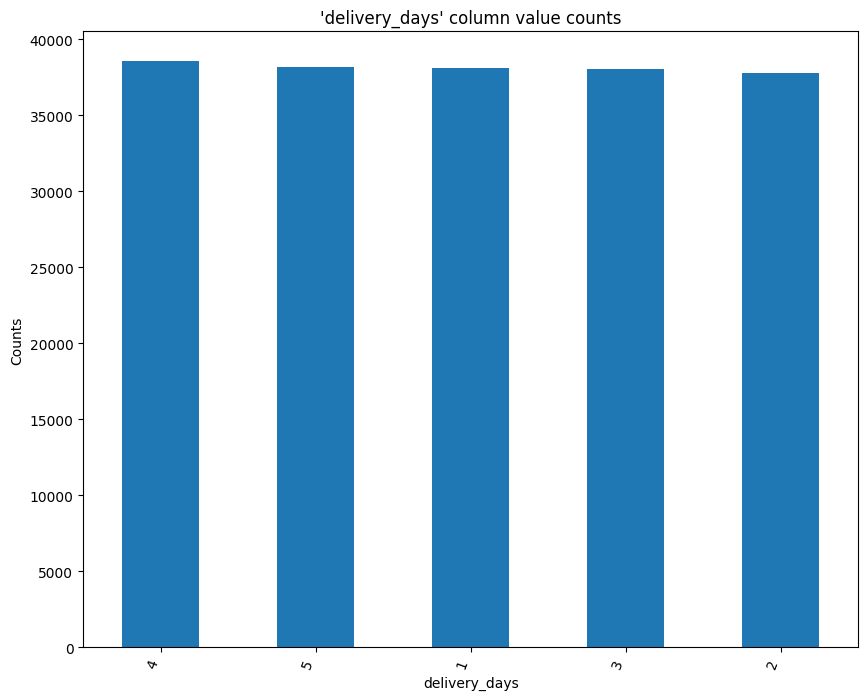

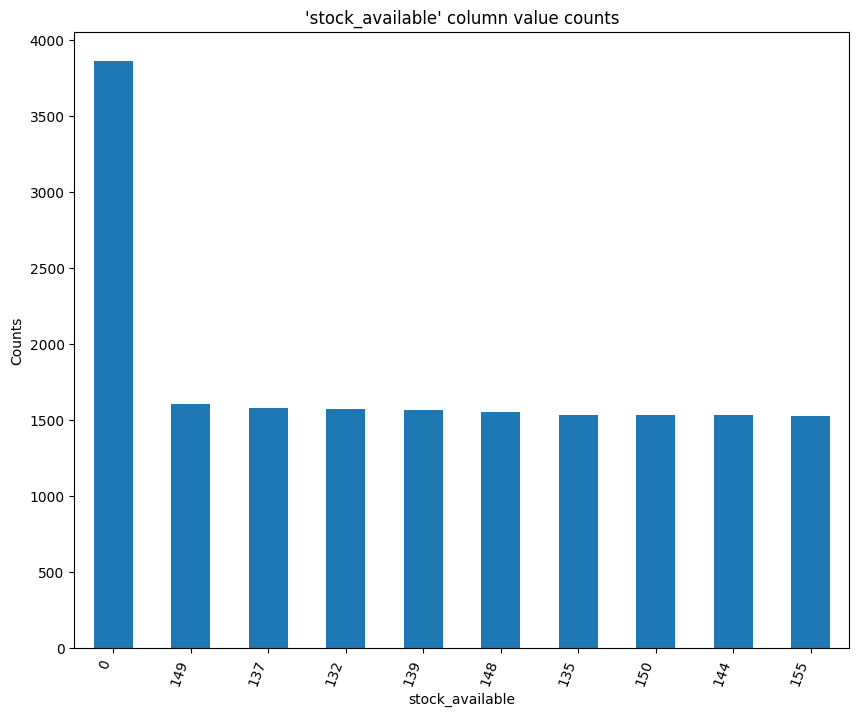

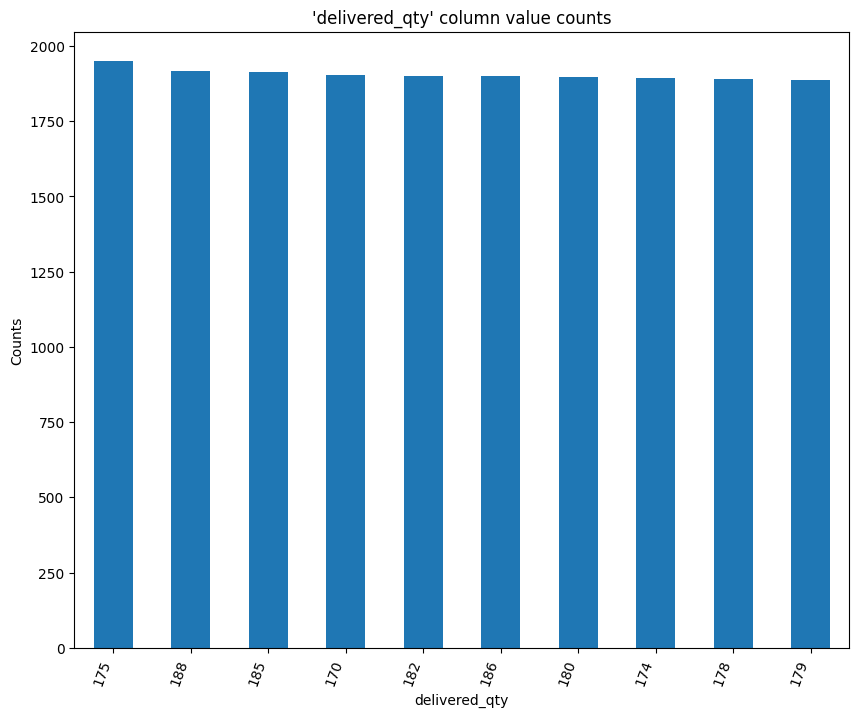

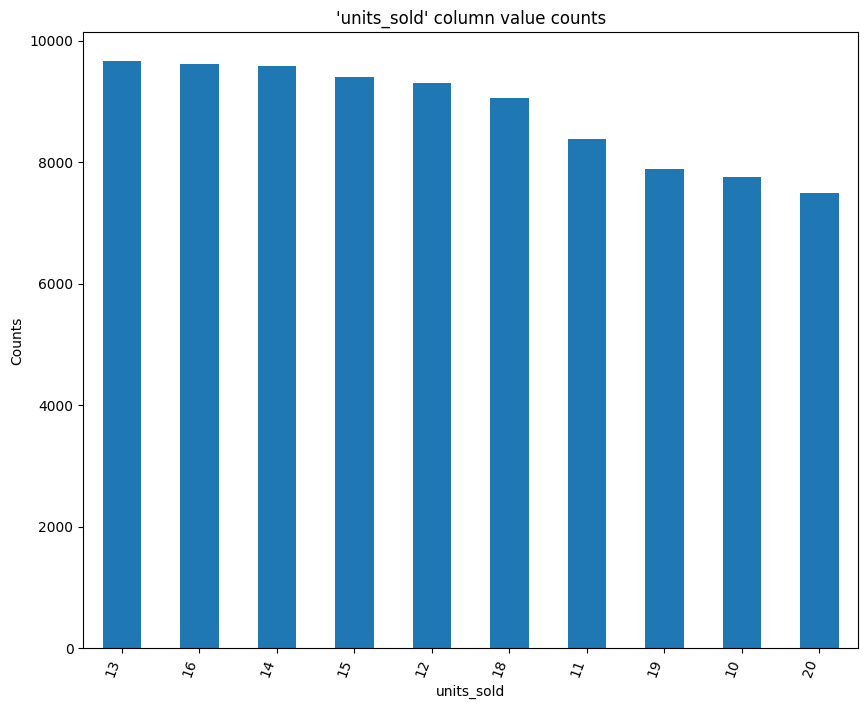

In [5]:
# Data Distribution
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

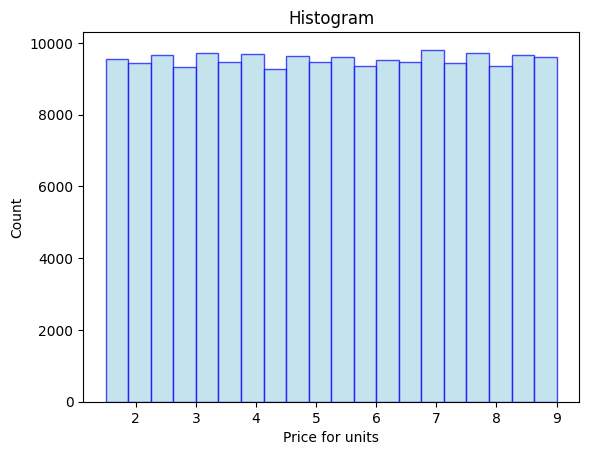

In [9]:
# Histogram (plt.hist)
plt.subplot(1, 1, 1)
#data = np.random.normal(0, 1, 1000)
plt.hist(data=df, x='price_unit', bins=20, 
         color='lightblue', edgecolor='blue', alpha=0.7)
plt.title('Histogram')
plt.xlabel('Price for units')
plt.ylabel('Count'); 

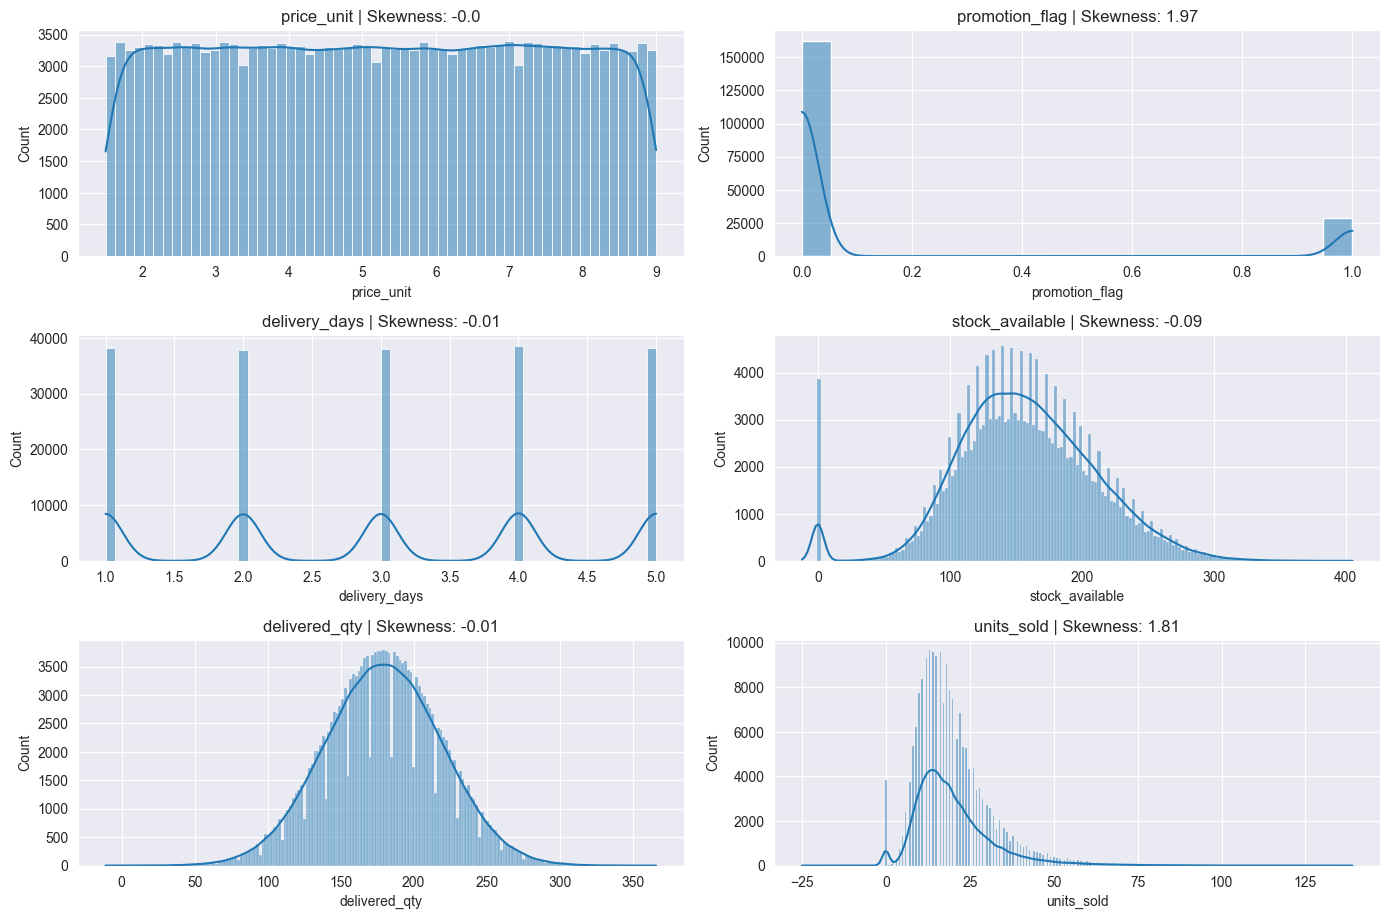

In [10]:
# Kernel Density Plot for understanding variance in the dataset
sns.set_style("darkgrid")
numerical_columns = df.select_dtypes(include=["int", "float"]).columns 
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

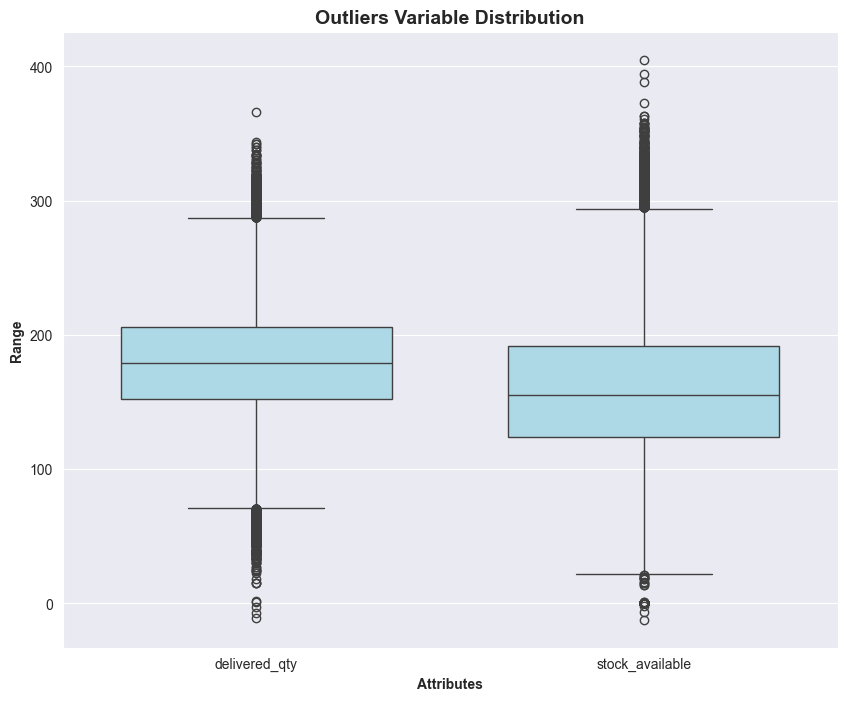

In [15]:
# Outliers
# Visualize Outlier Analysis of many columns at once
attributes = ['delivered_qty','stock_available']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df[attributes], orient="v",  color="lightblue",
whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [42]:
# Removing (statistical) outliers for any column
Q1 = df.delivered_qty.quantile(0.25)
Q3 = df.delivered_qty.quantile(0.75)
IQR = Q3 - Q1
print(f"Shape {df.shape} with Outliers")
df = df[(df.delivered_qty >= Q1 - 1.5 * IQR) & (df.delivered_qty <= Q3 + 1.5 * IQR)] 

# Removing (statistical) outliers for any column
Q1 = df.stock_available.quantile(0.25)
Q3 = df.stock_available.quantile(0.75)
IQR = Q3 - Q1
df = df[(df.stock_available >= Q1 - 1.5 * IQR) & (df.stock_available <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers")  

Shape (172722, 14) with Outliers
Shape (172722, 14) without Outliers


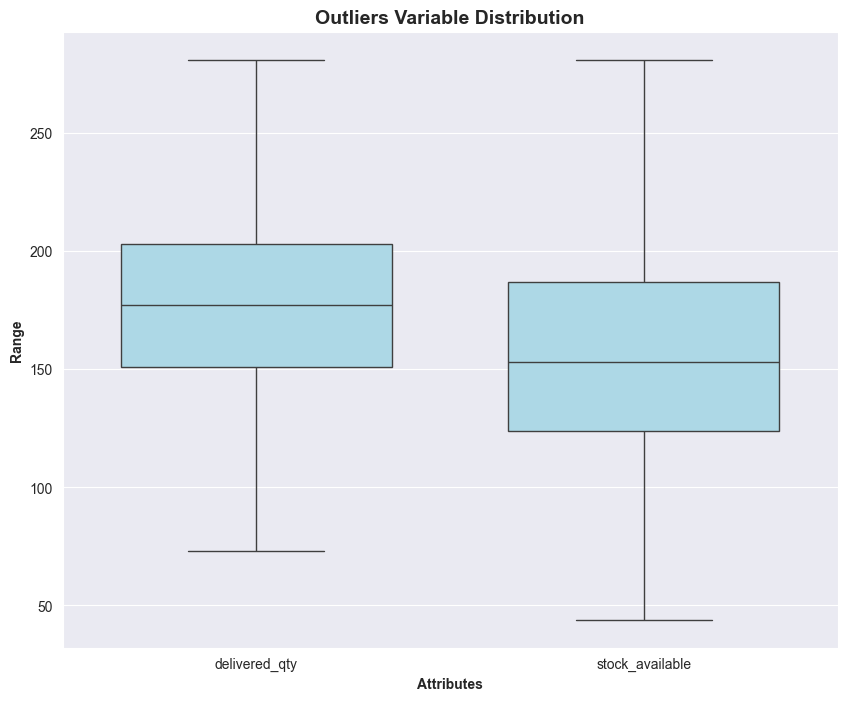

In [43]:
# Outliers
# Visualize Outlier Analysis of many columns at once
attributes = ['delivered_qty','stock_available']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df[attributes], orient="v",  color="lightblue",
whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

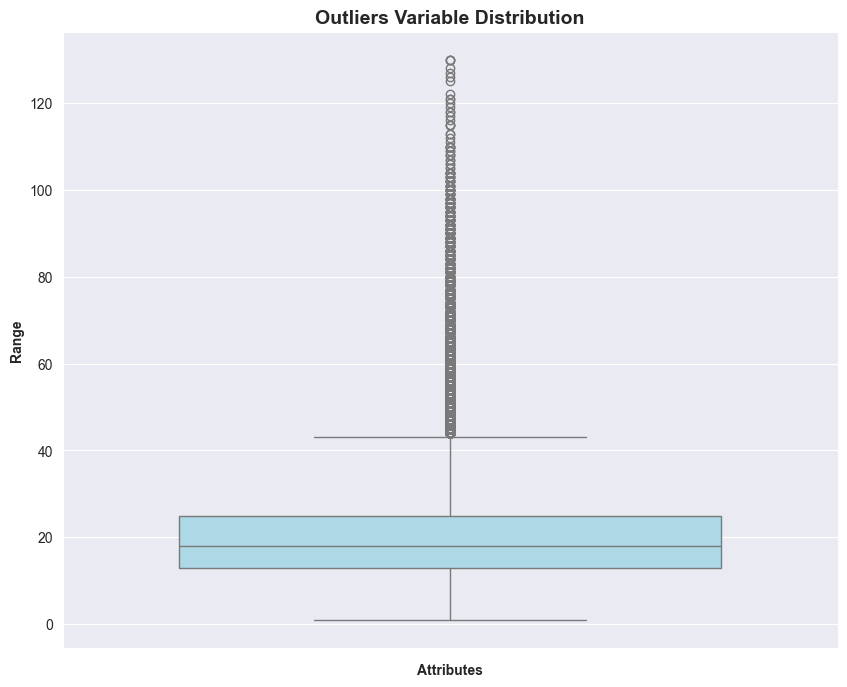

In [25]:
# Outliers
# Visualize Outlier Analysis of many columns at once
#attributes = ['delivered_qty','stock_available']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['units_sold'], orient="v",  color="lightblue",
whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [31]:
# Removing (statistical) outliers for any column
Q1 = df.units_sold.quantile(0.25)
Q3 = df.units_sold.quantile(0.75)
IQR = Q3 - Q1
print(f"Shape {df.shape} with Outliers")
df = df[(df.units_sold >= Q1 - 1.5 * IQR) & (df.units_sold <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers")  

Shape (173519, 14) with Outliers
Shape (173519, 14) without Outliers


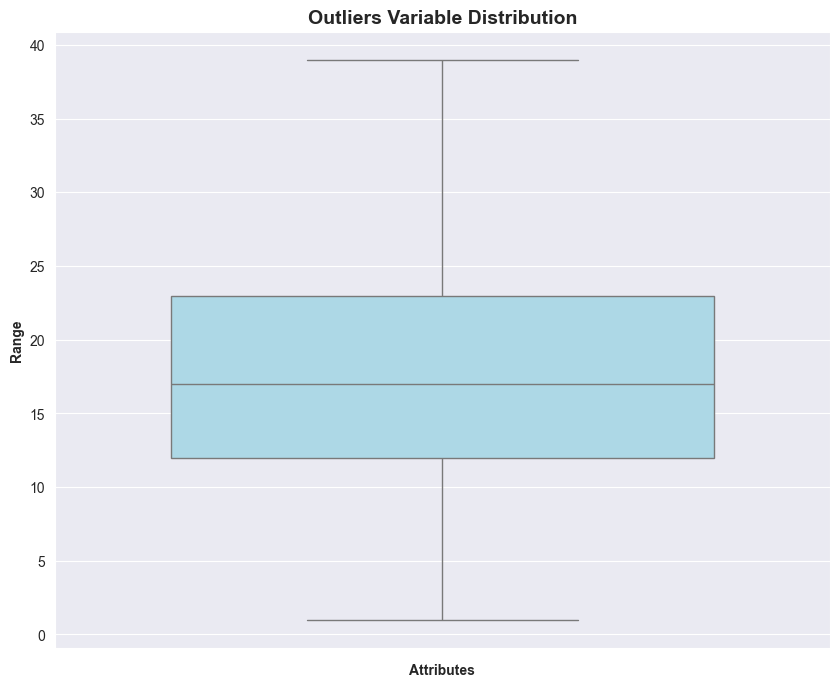

In [44]:
# Outliers
# Visualize Outlier Analysis of many columns at once
#attributes = ['delivered_qty','stock_available']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['units_sold'], orient="v",  color="lightblue",
whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [45]:
# Group by multiple columns
total_sales = df.groupby(['category', 'channel', 'pack_type'])[['units_sold']]\
    .sum().sort_values(by='units_sold', ascending=False)  
total_sales

units_sold
category  channel    pack_type            
Yogurt    Discount   Multipack      139642
          E-commerce Carton         137453
          Retail     Carton         137359
                     Single         137170
          E-commerce Multipack      137125
          Retail     Multipack      136997
          Discount   Carton         135868
                     Single         135729
          E-commerce Single         133607
Milk      E-commerce Single          78347
          Retail     Carton          77244
                     Multipack       76968
          E-commerce Carton          76752
          Discount   Multipack       76502
                     Carton          76369
          Retail     Single          76178
          E-commerce Multipack       75289
          Discount   Single          75056
ReadyMeal Discount   Single          65207
          E-commerce Multipack       64569
                     Single          64515
          Retail     Multipack       64265
                     Carton          64179
          Discount   Carton          64064
          Retail     Single          63063
          E-commerce Carton          62822
          Discount   Multipack       62435
SnackBar  Discount   Single          60950
          Retail     Carton          60898
          E-commerce Carton          60494
          Discount   Carton          60409
          E-commerce Single          60226
                     Multipack       59491
          Retail     Multipack       59142
                     Single          59121
          Discount   Multipack       56812
Juice     E-commerce Single          12269
          Discount   Carton          12256
                     Multipack       12092
          Retail     Single          12018
          E-commerce Carton          12008
          Discount   Single          11996
          Retail     Carton          11780
          E-commerce Multipack       11777
          Retail     Multipack       11253

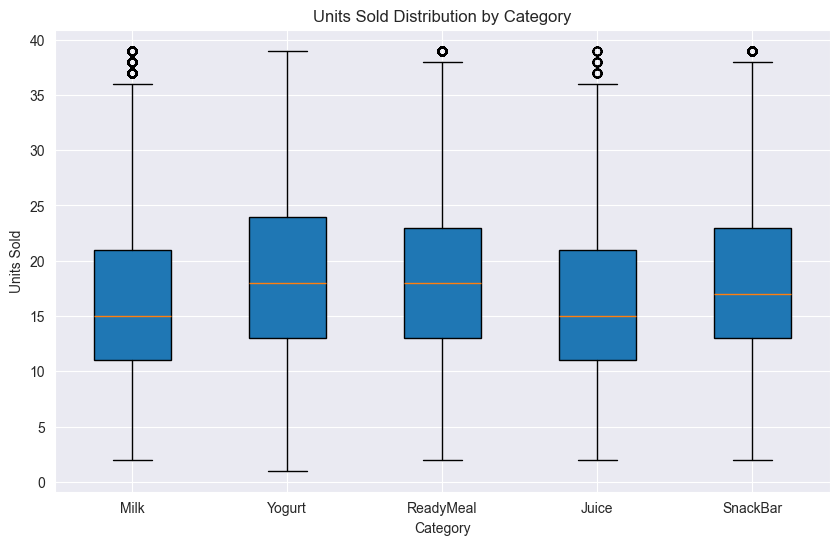

In [46]:
# Method 1: Using pandas groupby (recommended)
plt.figure(figsize=(10, 6))
data_grouped = [df[df['category'] == size]['units_sold'] for size in df['category'].unique()]
plt.boxplot(data_grouped, tick_labels=df['category'].unique(), patch_artist=True)
plt.title('Units Sold Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Units Sold')
plt.show()  

In [48]:
df.drop(columns=['date','sku'], axis=1, inplace=True)

In [50]:
# Label Encoding
# Check for categorical columns
df.select_dtypes(include=['object', 'category']).head(3) 

# Option 1: Use a loop for multiple columns
categorical_cols = df.select_dtypes(include=['object', 'category'])
label_encoders = {} 

for col in categorical_cols: 
    le = LabelEncoder() 
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for potential inverse transform

In [52]:
# Drop categorical columns
df.drop(df.select_dtypes(include=['object', 'category']), axis=1, inplace=True) 

In [57]:
X = df.drop(columns=['units_sold'], axis=1)
y = df['units_sold']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print() 

# For short dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

Dataset shape: (172722, 11)
Feature names: Index(['price_unit', 'promotion_flag', 'delivery_days', 'stock_available', 'delivered_qty', 'brand_encoded', 'segment_encoded', 'category_encoded', 'channel_encoded', 'region_encoded', 'pack_type_encoded'], dtype='object')

X Train shape: (138177, 11)
Y Train shape: (138177,)
X Test shape: (34545, 11)
Y Test shape: (34545,)
-------------------------------------------------------------------------------------------------------------------------------


=== Linear Regression Tuning Examples ===
=== Feature Correlation Analysis ===


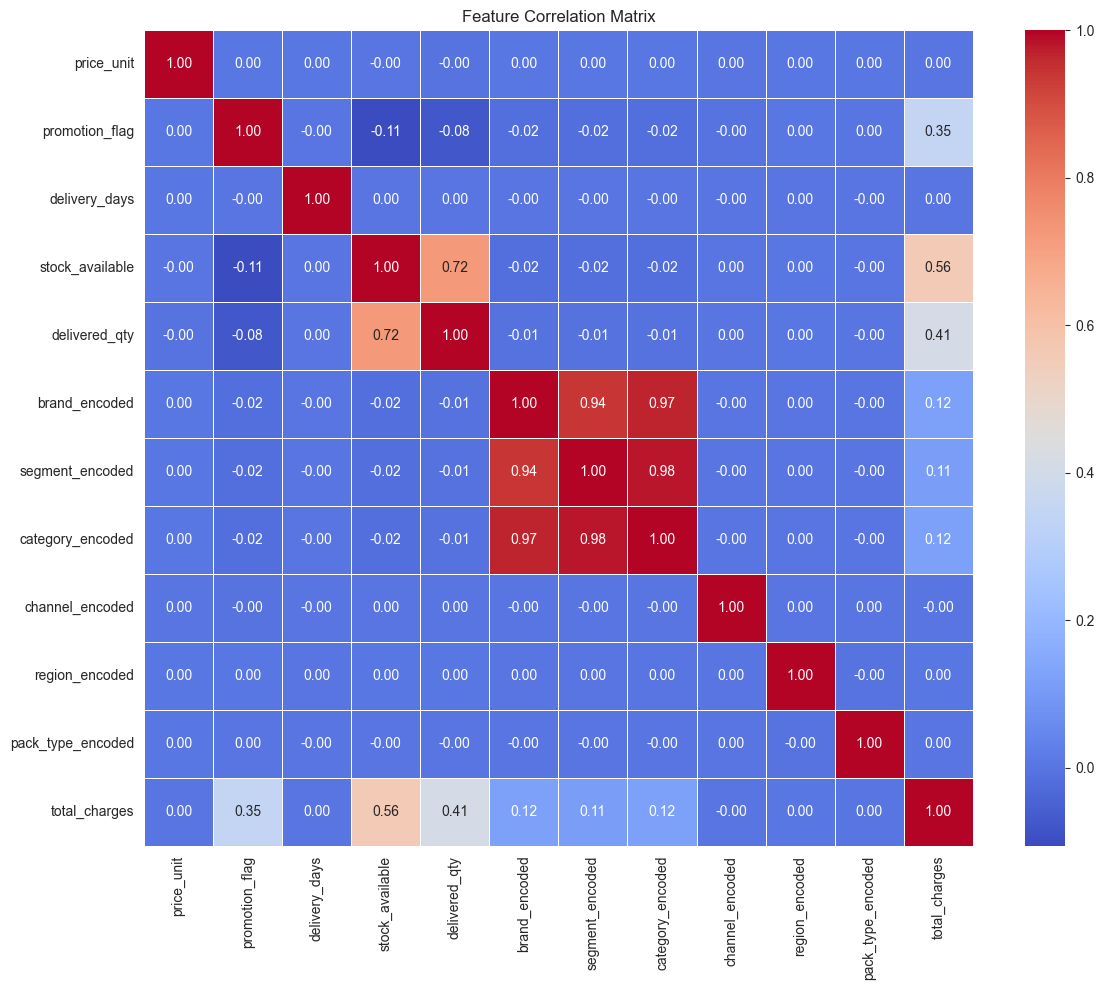

Feature correlation with target (total_charges):
total_charges        1.000000
stock_available      0.560100
delivered_qty        0.409097
promotion_flag       0.350213
category_encoded     0.122042
brand_encoded        0.120003
segment_encoded      0.113521
region_encoded       0.004420
delivery_days        0.001524
price_unit           0.000167
pack_type_encoded    0.000027
channel_encoded     -0.000386
Name: total_charges, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
=== Cross-Validation ===
Cross-Validation MSE: 29.3566 ± 0.2723
Cross-Validation MAE: 4.2384 ± 0.0258
Cross-Validation R²: 0.5048 ± 0.0014
-------------------------------------------------------------------------------------------------------------------------------
=== Basic Linear Regression ===
MSE test set: 29.1259
MSE train set: 29.4090

R² Score test: 0.5055
R² Score train: 0.5047

MAE test set: 4.2135
MAE train set: 

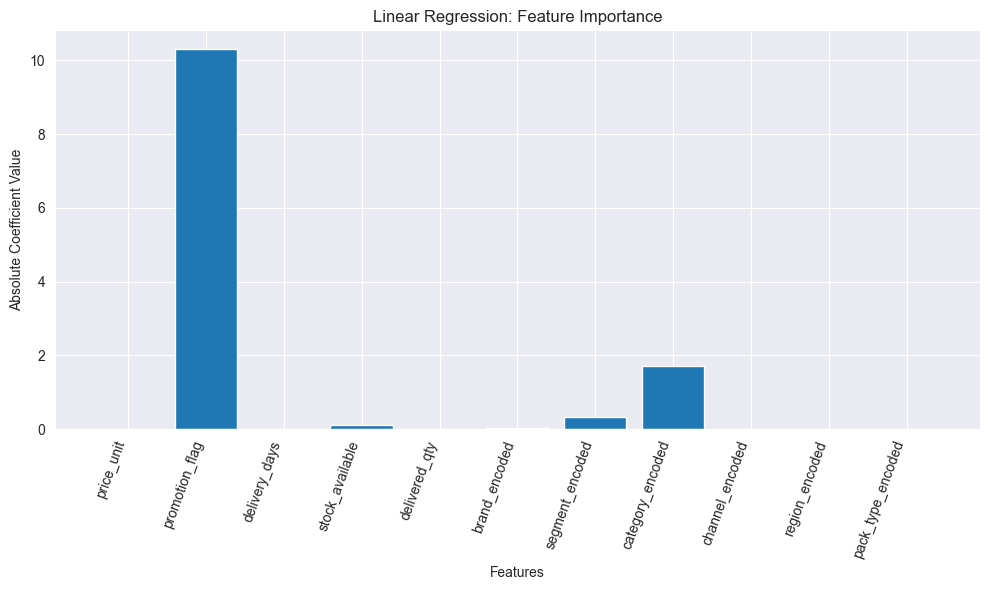

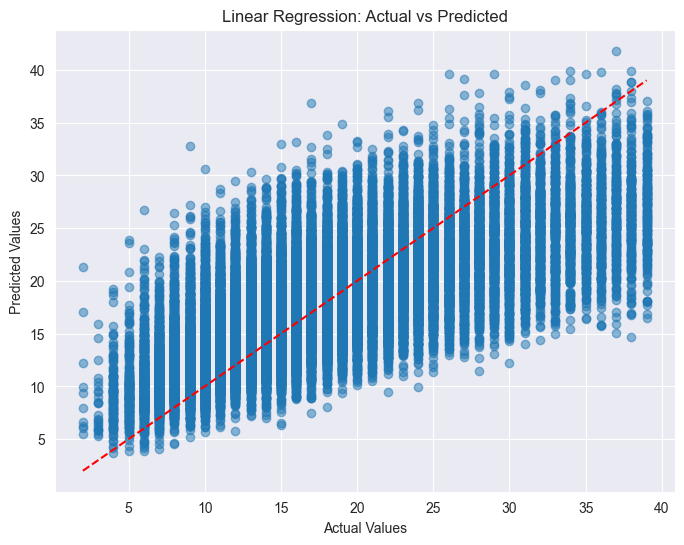

=== Scaled Linear Regression ===
MSE test set: 29.1259
MSE train set: 29.4090

R² Score test: 0.5055
R² Score train: 0.5047

MAE test set: 4.2135
MAE train set: 4.2442

Selected Features Coef_: ['price_unit' 'promotion_flag' 'delivery_days' 'stock_available'
 'delivered_qty' 'brand_encoded' 'segment_encoded' 'category_encoded'
 'channel_encoded' 'region_encoded' 'pack_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


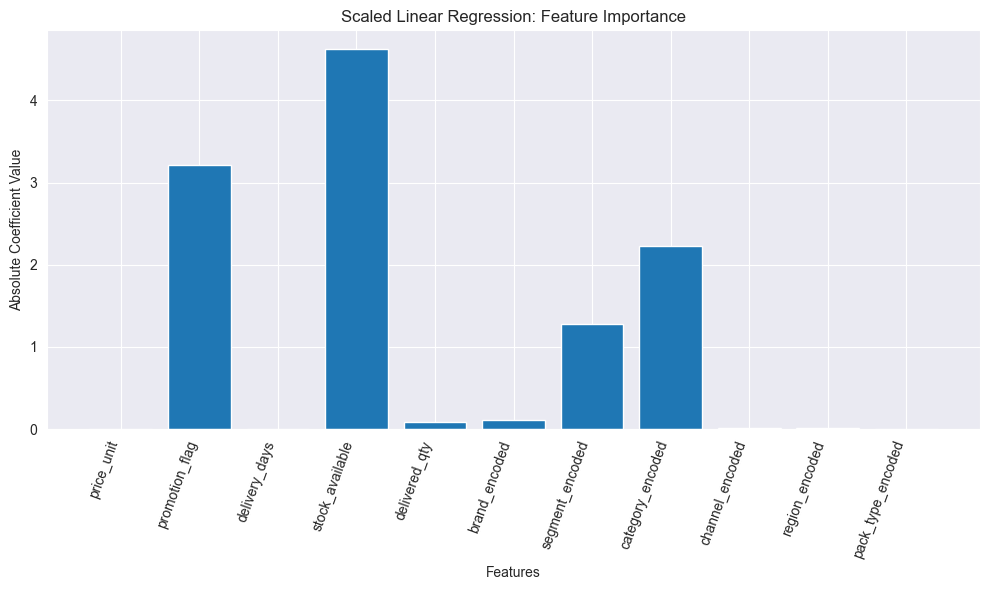

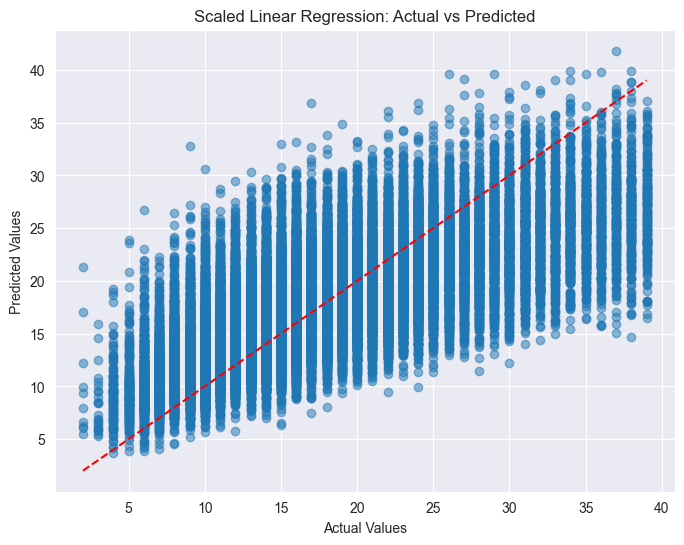

=== Feature Selection (SelectKBest) ===
MSE test set: 29.1815
MSE train set: 29.4752

R² Score test: 0.5045
R² Score train: 0.5036

MAE test set: 4.2179
MAE train set: 4.2497

Selected Features Selector : ['promotion_flag' 'stock_available' 'delivered_qty' 'brand_encoded'
 'category_encoded']
-------------------------------------------------------------------------------------------------------------------------------


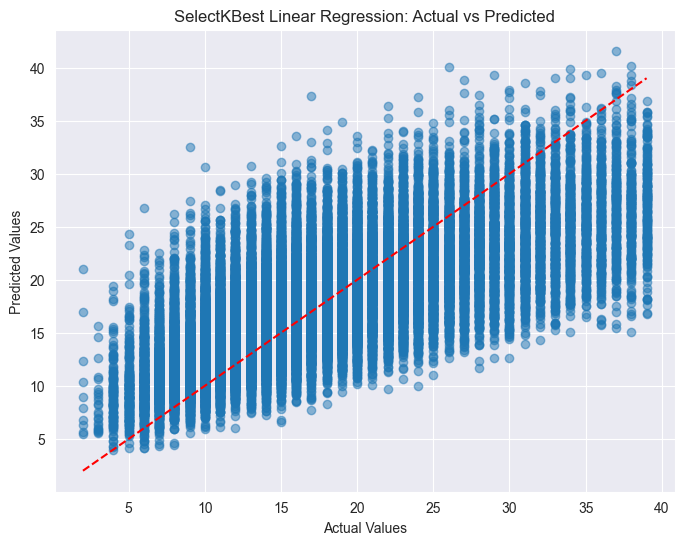

=== Feature Selection (RFE) ===
MSE test set: 29.1217
MSE train set: 29.4129

R² Score test: 0.5055
R² Score train: 0.5047

MAE test set: 4.2133
MAE train set: 4.2442

Selected Features Selector : ['promotion_flag' 'stock_available' 'brand_encoded' 'segment_encoded'
 'category_encoded']
-------------------------------------------------------------------------------------------------------------------------------


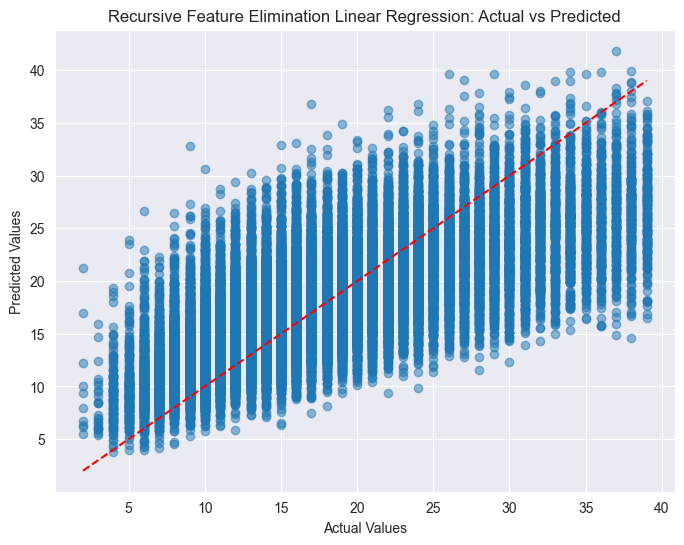

=== Polynomial Regression ===
MSE test set: 28.8411
MSE train set: 29.0043

R² Score test: 0.5103
R² Score train: 0.5116

MAE test set: 4.1936
MAE train set: 4.2172

Selected Features Coef_: ['price_unit' 'promotion_flag' 'delivery_days' 'stock_available'
 'delivered_qty' 'brand_encoded' 'segment_encoded' 'category_encoded'
 'channel_encoded' 'region_encoded' 'pack_type_encoded' 'price_unit^2'
 'price_unit promotion_flag' 'price_unit delivery_days'
 'price_unit stock_available' 'price_unit delivered_qty'
 'price_unit brand_encoded' 'price_unit segment_encoded'
 'price_unit category_encoded' 'price_unit channel_encoded'
 'price_unit region_encoded' 'price_unit pack_type_encoded'
 'promotion_flag^2' 'promotion_flag delivery_days'
 'promotion_flag stock_available' 'promotion_flag delivered_qty'
 'promotion_flag brand_encoded' 'promotion_flag segment_encoded'
 'promotion_flag category_encoded' 'promotion_flag channel_encoded'
 'promotion_flag region_encoded' 'promotion_flag pack_type_encod

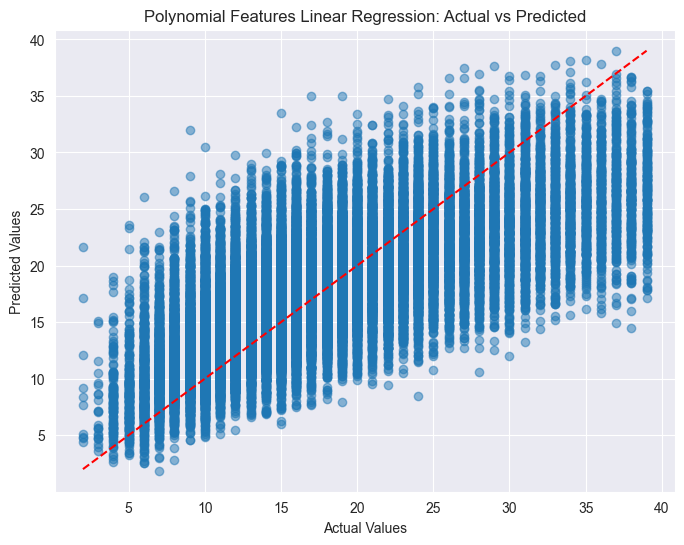

=== Ridge Regression ===
MSE test set:  29.1260
MSE train set: 29.4090

R² Score test: 0.5055
R² Score train:0.5047

MAE test set:  4.2135
MAE train set: 4.2442

Best alpha:    10.0000

Selected Features Coef_: ['price_unit' 'promotion_flag' 'delivery_days' 'stock_available'
 'delivered_qty' 'brand_encoded' 'segment_encoded' 'category_encoded'
 'channel_encoded' 'region_encoded' 'pack_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


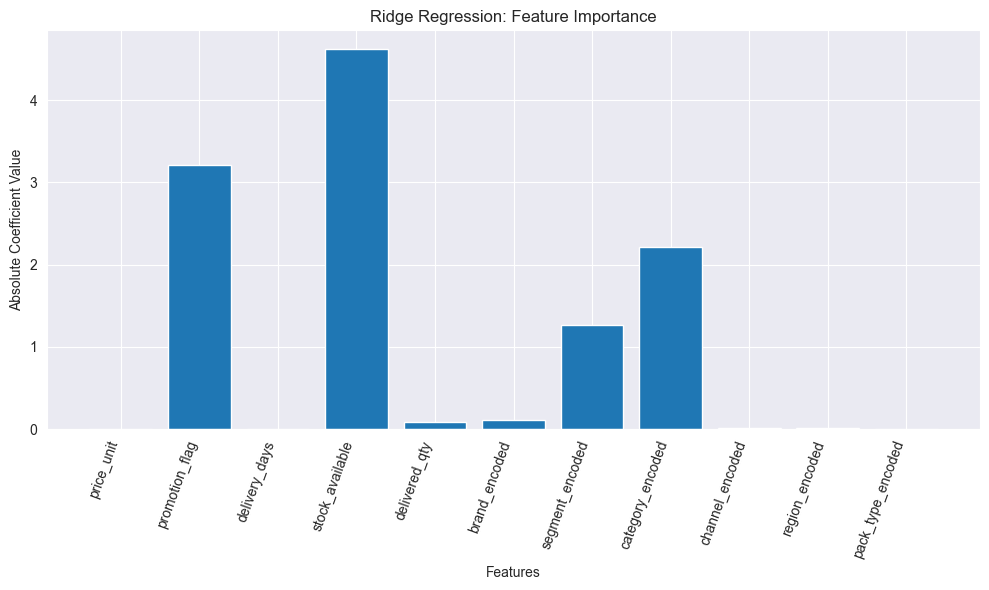

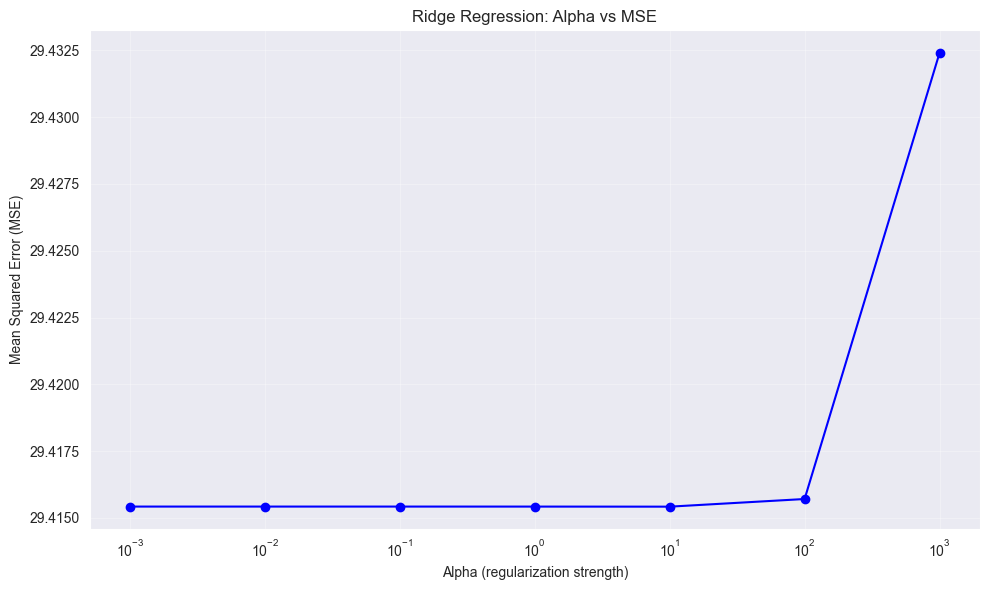

=== Lasso Regression ===
MSE test set: 29.1257
MSE train set: 29.4091

R² Score test: 0.5055
R² Score train: 0.5047

MAE test set: 4.2135
MAE train set: 4.2442

Best alpha: 0.001

Selected features: ['price_unit' 'promotion_flag' 'delivery_days' 'stock_available'
 'delivered_qty' 'brand_encoded' 'segment_encoded' 'category_encoded'
 'channel_encoded' 'region_encoded' 'pack_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


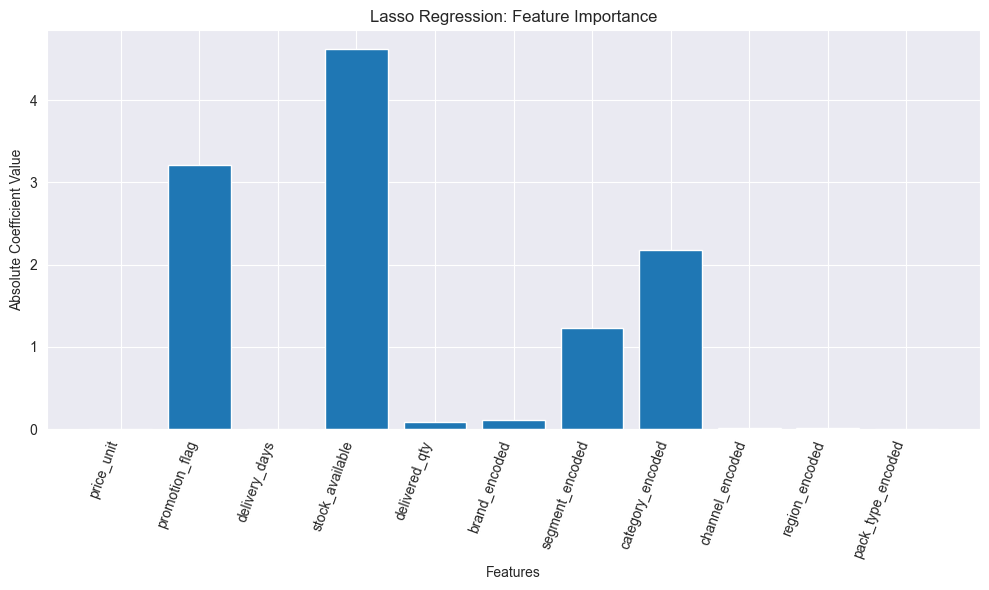

=== Elastic Net Regression ===
MSE test set: 29.1257
MSE train set: 29.4091

R² Score test: 0.5055
R² Score train: 0.5047

MAE test set: 4.2135
MAE train set: 4.2442

Best parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.99}

Selected Features Coef_: ['price_unit' 'promotion_flag' 'delivery_days' 'stock_available'
 'delivered_qty' 'brand_encoded' 'segment_encoded' 'category_encoded'
 'channel_encoded' 'region_encoded' 'pack_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


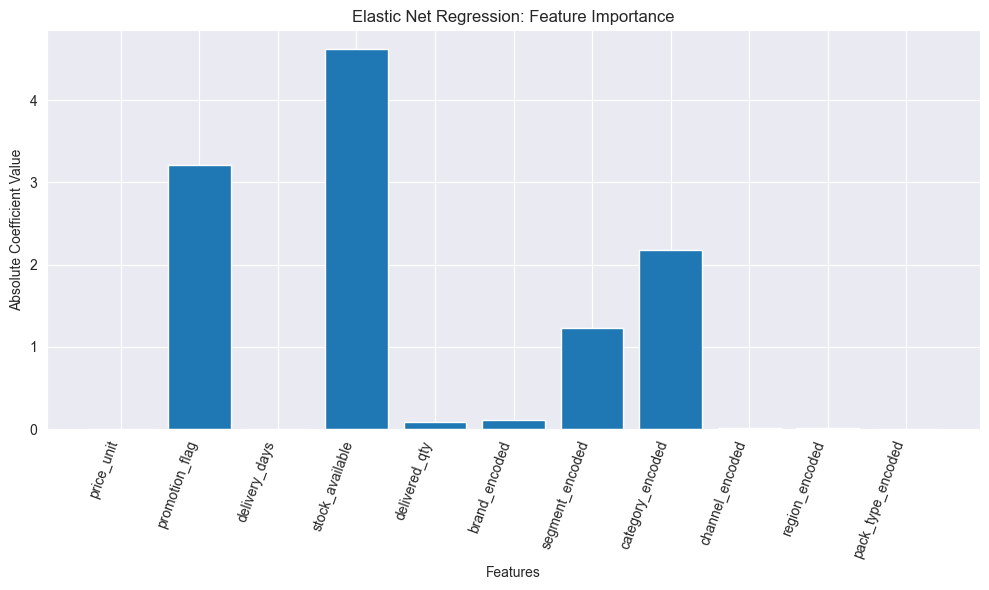

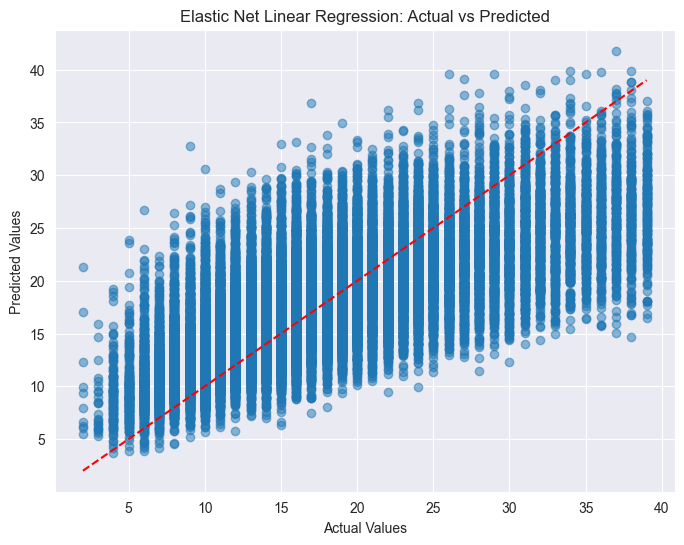

-------------------------------------------------------------------------------------------------------------------------------
=== Model Comparison ===
                                 MAE       MSE        R²
Feature Selection (KBest)  29.181451  0.504521  4.217904
Ridge Regression           29.125950  0.505463  4.213483
Basic Linear Regression    29.125913  0.505464  4.213473
Scaled Linear Regression   29.125913  0.505464  4.213473
Elastic Net                29.125688  0.505468  4.213525
Lasso Regression           29.125678  0.505468  4.213524
Feature Selection (RFE)    29.121721  0.505535  4.213260
Polynomial Regression      28.841059  0.510300  4.193610
-------------------------------------------------------------------------------------------------------------------------------
Best model according to MAE: Feature Selection (KBest)
Best model according to MSE: Feature Selection (KBest)
Best model according to RMSE: Feature Selection (KBest)
Best model according to R2_score: Featur

In [58]:
# Basic Linear Regression model
def basic_linear_regression():
    print("=== Basic Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n") 
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    
    # Check which features were selected (non-zero coefficients)
    lr_coef = model.coef_
    selected_features = np.array(X_train.columns)[lr_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()

    return model, mse_test, r2_test, mae_test

# Feature Scaling
def scaled_linear_regression():
    print("=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    # Check which features were selected (non-zero coefficients)
    scaled_lr_coef = pipeline.named_steps['regression'].coef_
    selected_features = np.array(X_train.columns)[scaled_lr_coef != 0]
    print(f"Selected Features Coef_: {selected_features}") 
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(scaled_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Scaled Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scaled Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with SelectKBest
def feature_selection_kbest():
    print("=== Feature Selection (SelectKBest) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SelectKBest Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with Recursive Feature Elimination (RFE)
def feature_selection_rfe():
    print("=== Feature Selection (RFE) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', RFE(LinearRegression(), n_features_to_select=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}") 
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Recursive Feature Elimination Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Polynomial Features
def polynomial_regression():
    print("=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}") 

    # Get the polynomial feature names
    poly_features = pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
    
    # Get coefficients from the regression step
    poly_coef = pipeline.named_steps['regression'].coef_
    
    # Find selected features (non-zero coefficients)
    selected_features = poly_features[poly_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Features Linear Regression: Actual vs Predicted')
    plt.show()  
    
    return pipeline, mse_test, r2_test, mae_test

# Regularized Linear Regression - Ridge
def ridge_regression():
    print("=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set:  {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train:{r2_train:.4f}\n")
    print(f"MAE test set:  {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    print(f"Best alpha:    {grid_search.best_params_['ridge__alpha']:.4f}")
  
    # Check which features were selected (non-zero coefficients)
    ridge_lr_coef = grid_search.best_estimator_['ridge'].coef_
    selected_features = np.array(X_train.columns)[ridge_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(ridge_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Ridge Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores, 'b-o')
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Regularized Linear Regression - Lasso
def lasso_regression():
    print("=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")   
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}") 
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    selected_features = np.array(X_train.columns)[lasso_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lasso_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Elastic Net
def elastic_net_regression():
    print("=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")    
    print(f"Best parameters: {grid_search.best_params_}")

    # Check which features were selected (non-zero coefficients)
    elastic_lr_coef = grid_search.best_estimator_['elasticnet'].coef_
    selected_features = np.array(X_train.columns)[elastic_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(elastic_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Elastic Net Regression: Feature Importance')
    plt.tight_layout()
    plt.show()  
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Linear Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Cross-validation with MAE, MSE, and R² scores
def cross_validation_example():
    print("-" * 127)
    print("=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate different metrics
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(mse_scores)
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"Cross-Validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("-" * 127) 
    
    return mse_scores, mae_scores, r2_scores, rmse_scores
        
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
        'Feature Selection (KBest)': feature_selection_kbest(),
        'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
        'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }

    # Extract MSE and R² scores
    results = {name: {'MAE': mae_scores, 'MSE': mse_scores, 'R²': r2_scores} 
           for name, (_, mae_scores, mse_scores, r2_scores) in models.items()} 

    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE')
    
    print("=== Model Comparison ===")
    print(results_df)
    print("-" * 127) 
    
    return results_df 

    # Plot comparison
    plt.figure(figsize=(12, 15))  # Increase height for 3 subplots

    plt.subplot(3, 1, 1)  # This now works with 3 rows
    plt.bar(results_df.index, results_df['MAE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE (lower is better)')
    
    plt.subplot(3, 1, 2)  # Change to 3 rows
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(3, 1, 3)  # Change to 3 rows
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')

    plt.tight_layout()
    plt.show()
    
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df, columns=X_train.columns)  # Always change the df value based on the df's name you're using
    X_df['total_charges'] = y_train  # Always change the X_df value 
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corr = corr['total_charges'].sort_values(ascending=False) # Always change the target_coor value 
    print("Feature correlation with target (total_charges):")  # Always change the variable value 
    print(target_corr)
    
    return corr

# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print(f"Best model according to MAE: {results.index[0]}")
    print(f"Best model according to MSE: {results.index[0]}")
    print(f"Best model according to RMSE: {results.index[0]}")
    print(f"Best model according to R2_score: {results.index[0]}")
    print("-" * 127) 

In [ ]:
print(f"The best model for Dairy Products Dataset was {results.index[0]} with a Mean Squared Error of {results.iloc[0]['MSE']}")

In [53]:
df.head(3)

,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold,brand_encoded,segment_encoded,category_encoded,channel_encoded,region_encoded,pack_type_encoded
0,2.38,0,1,141,128,9,1,3,1,2,0,1
2,4.00,0,5,118,161,8,1,3,1,2,2,0
3,5.16,0,2,81,114,7,1,3,1,0,0,2
